In [1]:
import requests
import pandas as pd
import requests_cache
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
import warnings

api_token = os.environ.get('EODHD_API_TOKEN')
requests_cache.install_cache('cache')

def get_sp500_tickers():

    INDEX_NAME = 'GSPC.INDX'
    url = f'https://eodhd.com/api/mp/unicornbay/spglobal/comp/{INDEX_NAME}'
    query = {'api_token': api_token, "fmt": "json"}

    data = requests.get(url, params=query)

    if data.status_code != 200:
        tqdm.write(f"Error: {data.status_code}")
        tqdm.write(data.text)
        return []

    data = data.json()
    df_stocks = pd.DataFrame(data['Components']).T.reset_index()

    df_stocks.to_csv('csv/stocks_universe.csv', index=False)
    tickers = df_stocks['Code'].tolist()
    return tickers

# Get S&P 500 tickers
sp500_tickers = get_sp500_tickers()

In [2]:
start_date = '2024-01-01'
sp_500_prices_df = pd.DataFrame()

for ticker in tqdm(sp500_tickers, desc="Fetching ticker data"):
    try:
        # Construct the API URL
        ticker_code = f"{ticker}.US"
        url = f'https://eodhd.com/api/eod/{ticker_code}'

        # Set query parameters
        query = {
            'api_token': api_token,
            'fmt': 'json',
            'from': start_date
        }

        response = requests.get(url, params=query)

        if response.status_code == 200:
            # Parse the JSON response
            data = response.json()

            # Convert to DataFrame
            ticker_df = pd.DataFrame(data)

            # Extract date and adjusted_close
            if 'adjusted_close' in ticker_df.columns:
                prices = ticker_df[['date', 'adjusted_close']].copy()
                prices.set_index('date', inplace=True)

                # Rename the column to the ticker symbol
                prices.rename(columns={'adjusted_close': ticker}, inplace=True)

                # Join with the main DataFrame
                if sp_500_prices_df.empty:
                    sp_500_prices_df = prices
                else:
                    sp_500_prices_df = sp_500_prices_df.join(prices, how='outer')

            else:
                tqdm.write(f"No adjusted close data available for {ticker}")
        else:
            tqdm.write(f"Error fetching data for {ticker}: {response.status_code}")
            tqdm.write(response.text)
    except Exception as e:
        tqdm.write(f"Exception occurred while processing {ticker}: {str(e)}")

returns = sp_500_prices_df.pct_change().dropna()
returns.head()

Fetching ticker data: 100%|██████████| 503/503 [00:02<00:00, 240.21it/s]
C:\Users\phitz\AppData\Local\Temp\ipykernel_31376\3546419437.py:48: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = sp_500_prices_df.pct_change().dropna()


,AIZ,MNST,MTCH,PGR,CSX,ADP,ANSS,AFL,SO,REG,...,KVUE,RVTY,VLTO,COR,TKO,CPAY,SOLV,GEV,SW,EXE
date,,,,,,,,,,,,,,,,,,,,,
2024-03-28,0.004429,0.001351,0.011149,0.003250,0.006242,0.005678,-0.002213,0.002804,0.009711,0.006482,...,0.000464,-0.003890,-0.012034,-0.006745,0.000232,0.009885,-0.072667,0.041905,0.006735,0.012539
2024-04-01,-0.005419,-0.025978,-0.010198,0.015134,-0.007822,-0.017738,0.000922,-0.007804,-0.008921,-0.015027,...,-0.010720,-0.016476,-0.012633,0.000041,-0.002661,-0.008556,-0.006470,0.038537,0.070234,0.010357
2024-04-02,-0.003204,-0.014548,-0.019216,0.000381,-0.007341,0.009580,-0.004892,-0.003052,0.003375,0.000334,...,-0.019307,-0.010264,-0.010966,0.000371,0.051636,0.014613,-0.031838,-0.014223,-0.040625,-0.008691
2024-04-03,-0.008842,-0.016696,0.015616,0.004001,-0.002467,-0.010216,0.002776,0.002944,-0.005046,0.001174,...,-0.023057,0.001369,0.007739,0.011148,0.021957,0.018591,-0.044993,-0.019000,0.000000,0.014948
2024-04-04,-0.030437,-0.003575,-0.057308,-0.007259,-0.008236,-0.014849,-0.016035,-0.009627,-0.013103,-0.010712,...,-0.008357,-0.006546,-0.006418,-0.015297,-0.008961,-0.035775,0.048677,-0.082132,0.000000,-0.010852


In [3]:
df = pd.DataFrame()

# Fetch fundamental data for each ticker
for ticker in tqdm(sp500_tickers, desc="Fetching fundamental data"):
    try:
        # Construct the API URL
        ticker_code = f"{ticker}.US"
        url = f'https://eodhd.com/api/fundamentals/{ticker_code}'

        # Set query parameters
        query = {
            'api_token': api_token,
            'fmt': 'json'
        }

        # Make the API request
        response = requests.get(url, params=query)

        # Check if the request was successful
        if response.status_code == 200:
            # Parse the JSON response
            data = response.json()

            # Extract the required metrics
            metrics = {
                'Ticker': ticker,
                'Name': data.get('General', {}).get('Name', None),
                'Sector': data.get('General', {}).get('Sector', None),
                'Industry': data.get('General', {}).get('Industry', None),
                'Market Capitalisation': data.get('Highlights', {}).get('MarketCapitalization', None),
                'P/E Ratio': data.get('Highlights', {}).get('PERatio', None)
            }

            # Add to the dataframe
            df = pd.concat([df, pd.DataFrame([metrics])], ignore_index=True)
        else:
            tqdm.write(f"Error fetching fundamental data for {ticker}: {response.status_code}")
            tqdm.write(response.text)
    except Exception as e:
        tqdm.write(f"Exception occurred while processing fundamental data for {ticker}: {str(e)}")

# Define capitalization bins and labels
bins = [0, 1e10, 1e11, 1e12, 1e13]
labels = ['Small (<10B)', 'Medium (10B-100B)', 'Large (100B-1T)', 'Mega (>1T)']

# Create a new column for capitalization bins
df['Cap_Bin'] = pd.cut(df['Market Capitalisation'], bins=bins, labels=labels)

Fetching fundamental data:   3%|▎         | 15/503 [00:00<00:03, 140.31it/s]C:\Users\phitz\AppData\Local\Temp\ipykernel_31376\3779001745.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([metrics])], ignore_index=True)
Fetching fundamental data: 100%|██████████| 503/503 [00:03<00:00, 139.40it/s]


In [4]:
sp_500_prices_df.index = pd.to_datetime(sp_500_prices_df.index)

# Sort by date
sp_500_prices_df = sp_500_prices_df.sort_index()

# Get the last 6 months of data
six_months_ago = sp_500_prices_df.index[-1] - pd.DateOffset(months=6)
six_month_prices = sp_500_prices_df[sp_500_prices_df.index >= six_months_ago]

# Calculate daily returns
daily_returns = six_month_prices.pct_change().dropna()

# Calculate volatility (standard deviation of returns)
volatility = daily_returns.std() * (252 ** 0.5)  # Annualized volatility

# Add volatility to the fundamentals dataframe
for ticker in sp500_tickers:
    if ticker in volatility.index:
        mask = df['Ticker'] == ticker
        df.loc[mask, '6-Month Volatility'] = volatility[ticker]

In [5]:
# Preprocessing
features = df[['Market Capitalisation','P/E Ratio','6-Month Volatility']]

# Normalize features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)

# Impute Missing Data
# The most common approach is to fill missing values with the mean, median, or another strategy using SimpleImputer from scikit-learn:

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')  # or 'median'
imputed_data = imputer.fit_transform(features)

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaled_data = scaler.fit_transform(imputed_data)

pca = PCA(n_components=0.95)
principal_components = pca.fit_transform(scaled_data)

from sklearn.cluster import KMeans

# # Elbow method for optimal clusters
# wcss = []
# for i in range(1, 11):
#     kmeans = KMeans(n_clusters=i)
#     kmeans.fit(principal_components)
#     wcss.append(kmeans.inertia_)

# Optimal cluster selection (visualize elbow point)
k = 11  # Typical for sector-based clustering
model = KMeans(n_clusters=k)
clusters = model.fit_predict(principal_components)
df['ClusterFeatures'] = clusters

<Figure size 1400x1000 with 0 Axes>

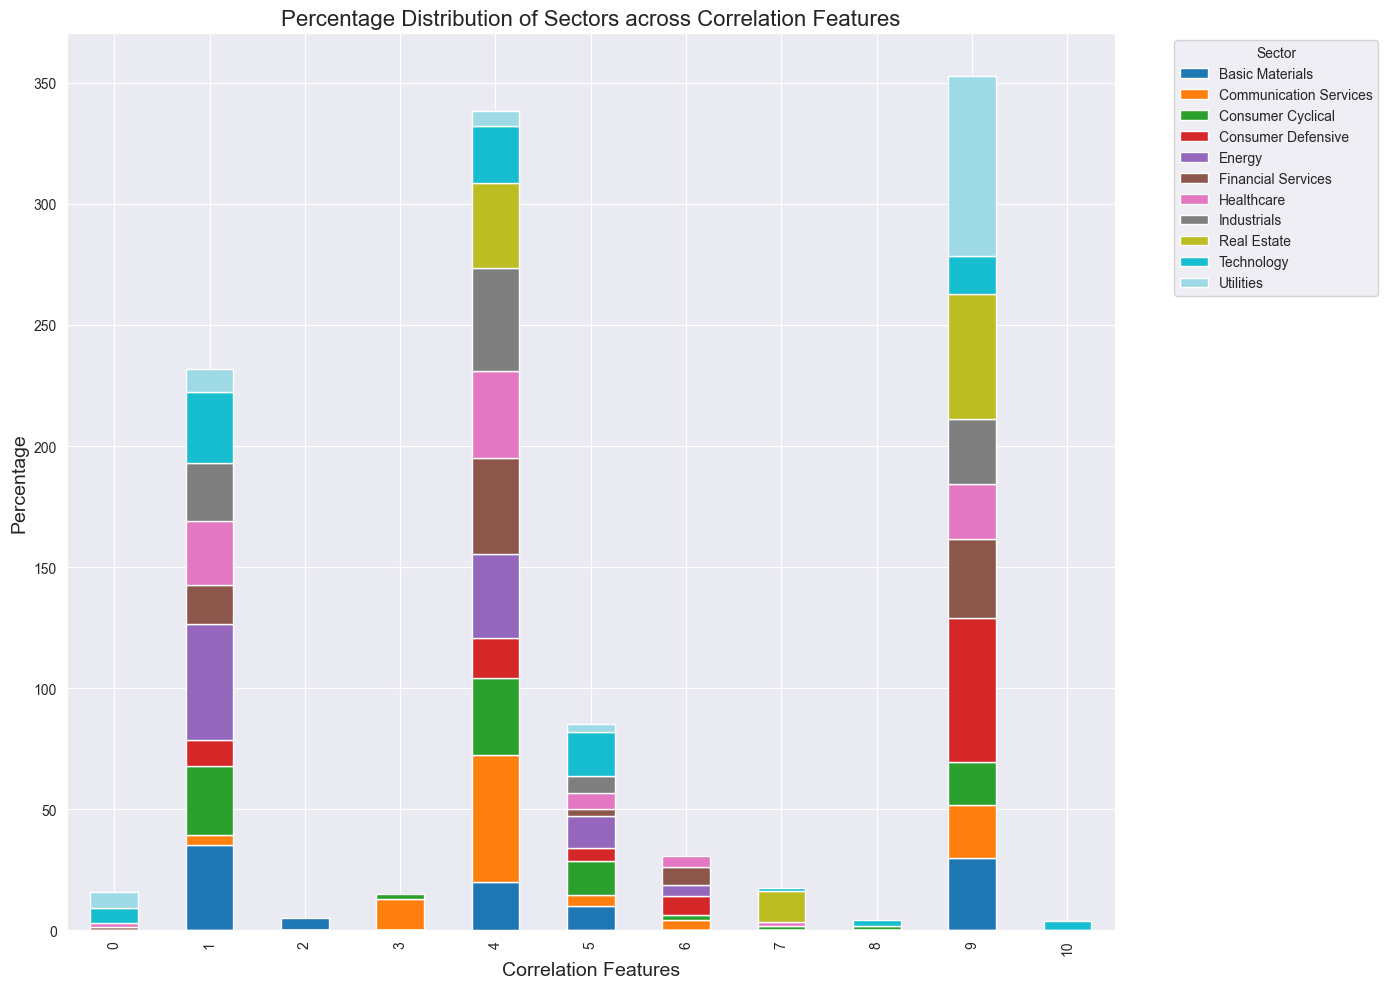

In [6]:
# Group by Sector and ClusterCorrelation, then count
sector_cluster_counts = df.groupby(['Sector', 'ClusterFeatures']).size().reset_index(name='Count')

# Pivot for a matrix view
pivot_table = sector_cluster_counts.pivot(index='Sector', columns='ClusterFeatures', values='Count').fillna(0).astype(int)

# Create a stacked bar chart
plt.figure(figsize=(14, 10))
pivot_table_percentage = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100

# Plot stacked bar chart
pivot_table_percentage.T.plot(kind='bar', stacked=True, figsize=(14, 10), colormap='tab20')
plt.title('Percentage Distribution of Sectors across Correlation Features', fontsize=16)
plt.xlabel('Correlation Features', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

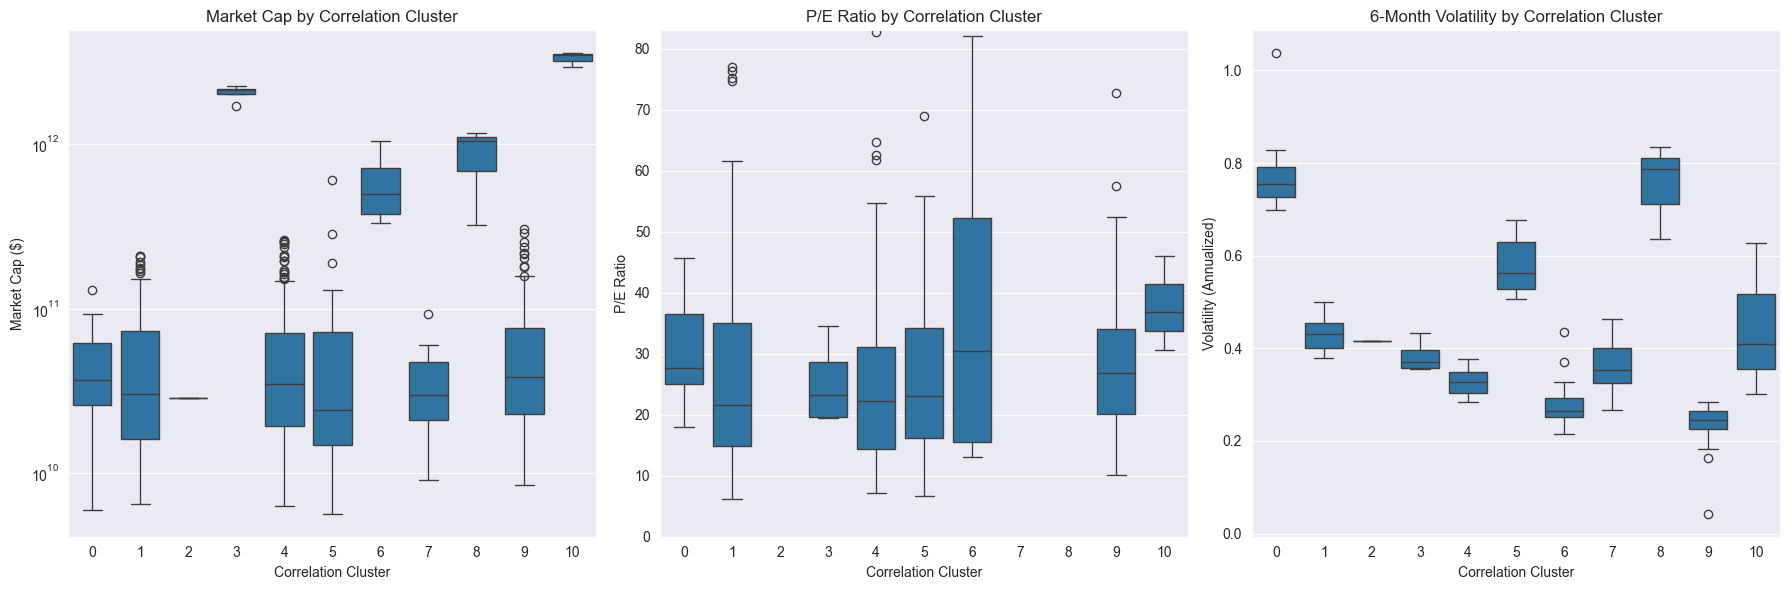

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure with 3 subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Boxplot for Market Capitalization
sns.boxplot(x='ClusterFeatures', y='Market Capitalisation', data=df, ax=axes[0])
axes[0].set_title('Market Cap by Correlation Cluster')
axes[0].set_ylabel('Market Cap ($)')
axes[0].set_xlabel('Correlation Cluster')
# Use log scale for Market Cap due to wide range
axes[0].set_yscale('log')

# Boxplot for P/E Ratio
sns.boxplot(x='ClusterFeatures', y='P/E Ratio', data=df, ax=axes[1])
axes[1].set_title('P/E Ratio by Correlation Cluster')
axes[1].set_ylabel('P/E Ratio')
axes[1].set_xlabel('Correlation Cluster')
# Set a reasonable y-limit to handle outliers
axes[1].set_ylim(0, df['P/E Ratio'].quantile(0.95))

# Boxplot for 6-Month Volatility
sns.boxplot(x='ClusterFeatures', y='6-Month Volatility', data=df, ax=axes[2])
axes[2].set_title('6-Month Volatility by Correlation Cluster')
axes[2].set_ylabel('Volatility (Annualized)')
axes[2].set_xlabel('Correlation Cluster')

plt.tight_layout()
plt.show()

In [8]:
import numpy as np

corr_matrix = returns.corr()

distance_matrix = np.sqrt(2 * (1 - corr_matrix))

from scipy.cluster.hierarchy import linkage, dendrogram

# Average linkage often performs best for financial data[1][5]
Z = linkage(distance_matrix, method='average')

from scipy.cluster.hierarchy import fcluster

# t is the number of clusters
clusters = fcluster(Z, t=11, criterion='maxclust')

df.to_csv('csv/sp500_clustered.csv', index=False)
df['ClusterCorrelation'] = clusters

C:\Users\phitz\AppData\Local\Temp\ipykernel_31376\3078464025.py:10: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='average')


In [ ]:
# Group by Sector and ClusterCorrelation, then count
sector_cluster_counts = df.groupby(['Sector', 'ClusterCorrelation']).size().reset_index(name='Count')

# Pivot for a matrix view
pivot_table = sector_cluster_counts.pivot(index='Sector', columns='ClusterCorrelation', values='Count').fillna(0).astype(int)

# Create a stacked bar chart
plt.figure(figsize=(14, 10))
pivot_table_percentage = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100

# Plot stacked bar chart
pivot_table_percentage.T.plot(kind='bar', stacked=True, figsize=(14, 10), colormap='tab20')
plt.title('Percentage Distribution of Sectors across Correlation Clusters', fontsize=16)
plt.xlabel('Correlation Cluster', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()